In [1]:
import os,glob
import numpy as np
import cv2
import alexnet
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def explore_dir(dir,count=0,f_extensions=None):
    if count==0:
        global n_dir, n_file, filenames, filelocations
        n_dir=n_file=0
        filenames=list()
        filelocations=list()

    for img_path in sorted(glob.glob(os.path.join(dir,'*' if f_extensions is None else '*.'+f_extensions))):
        if os.path.isdir(img_path):
            n_dir +=1
            explore_dir(img_path,count+1)
        elif os.path.isfile(img_path):
            n_file += 1
            filelocations.append(img_path)
            filenames.append(img_path.split("/")[-1])
    return np.array((filenames,filelocations))

In [3]:
tr_img_path = explore_dir('./fruits-360/Training/')[1]
te_img_path = explore_dir('./fruits-360/Test/')[1]

classes = list(set(path.split("/")[-2] for path in tr_img_path))

tr_imgset = np.array(list(map(cv2.imread,tr_img_path)))
te_imgset = np.array(list(map(cv2.imread,te_img_path)))

In [4]:
tr_label = list()
te_label = list()

for i in range(len(tr_img_path)): 
    tr_label.append((list(classes)).index(tr_img_path[i].split('/')[-2]))
    
for i in range(len(te_img_path)):
    te_label.append((list(classes)).index(te_img_path[i].split('/')[-2]))

In [5]:
# data shuffling
tr_img = tr_imgset.copy()
label = np.array(tr_label).copy()

idx = np.random.permutation(len(tr_img))
tr_img = tr_img[idx]
label = label[idx]

In [6]:
re_tr_img = np.array(list((lambda x : cv2.resize(x,(227,227)))(img) for img in tr_img))
re_te_img = np.array(list((lambda x : cv2.resize(x,(227,227)))(img) for img in te_imgset))

Carambula


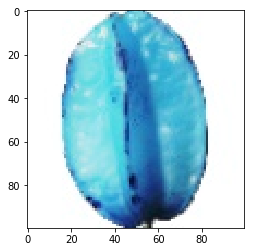

In [7]:
# for test 
idx=900
print(classes[label[idx]])
plt.imshow(tr_img[idx])

## Training

In [8]:
# gpu setting
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

batch_size = 500
iter_num = 10000
snapshot_step = 100
lowest_loss=None

In [9]:
tf.reset_default_graph()

In [10]:
# load net
net = alexnet.alexnet(input_shape=(227,227,3),output_shape=(75,)) 

with net.graph.as_default():
    saver = tf.train.Saver()
    
    summary_writer = tf.summary.FileWriter("./snapshot/gpu/", net.sess.graph)
    summary_op = tf.summary.merge_all()

In [11]:
def separate_batches(img,label):
    img_batches = list()
    label_batches = list()
        
    if(len(img)%batch_size==0):
        num_batches = len(img)//batch_size
        for nb in range(num_batches):
            img_batches.append(img[batch_size*nb:batch_size*(nb+1)])
            label_batches.append(label[batch_size*nb:batch_size*(nb+1)])
    else:
        num_batches = (len(img)//batch_size)+1
        for nb in range(num_batches):
            img_batches.append(img[batch_size*nb:batch_size*(nb+1)])
            label_batches.append(label[batch_size*nb:batch_size*(nb+1)])
            if(nb==num_batches-1):
                img_batches.append(img[batch_size*nb:])
                label_batches.append(label[batch_size*nb:])
                
    return img_batches,label_batches

In [12]:
def one_hot_encoding(labels,depth):
    return np.eye(depth)[labels].reshape(len(labels),depth)

In [13]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=net.fc8, labels=net.y_gt))
optimizer = tf.train.AdadeltaOptimizer(learning_rate=1,rho=0.95,epsilon=1e-09).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [14]:
prediction = tf.argmax(net.fc8,1)
target = tf.argmax(net.y_gt,1)

correct = tf.equal(prediction,target)
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

In [ ]:
net.sess.run(tf.global_variables_initializer())

with tf.device("/gpu:0"):
    for step in range(iter_num):
        tr_cost = 0.
        tr_acc = 0.
        tr_cnt = 0
        
        for n in range(tr_num_batches):
            acc, loss, _ = net.sess.run(
                [accuracy,cost,optimizer],
                feed_dict = {net.x: tr_img_batches[n],
                            net.y_gt : one_hot_encoding(tr_label_batches[n],75),
                            net.keep_prob:0.7})
            
            tr_cost+=loss
            tr_acc+=acc
            tr_cnt+=1
        
        print(tr_acc/tr_cnt,tr_cost/tr_cnt)

0.021695175251041195 5.593160905336079
0.016578947478831794 4.343183417069285
0.014078947614363738 4.319303575314973
